# Problem Statement

Fradulent Medicare claims is a serious problem impacting the healthcare industry. The purpose of this project is to build a predictive model to detect such claims and help insurance companies to act on those.

# Project Structure

* Data Understading
* Data Prepration
* Exploratory Data Analysis & Feature Engineering
* Modelling
* Model Evaluation
* Deployment

# Data Understanding

As a first step, all sample files will be imported into data frames and preliminary analysis is done.

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={"figure.figsize":(15, 10)})

In [88]:
file_path="./fraud_data"
in_patient=f"{file_path}/Train_Inpatientdata-1542865627584.csv"
out_patient=f"{file_path}/Train_Outpatientdata-1542865627584.csv"
bene=f"{file_path}/Train_Beneficiarydata-1542865627584.csv"
labelled=f"{file_path}/Train-1542865627584.csv"

In [89]:
df_in = pd.read_csv(in_patient)
df_out = pd.read_csv(out_patient)
df_bene = pd.read_csv(bene)
df_lab = pd.read_csv(labelled)

# Data Preparation

Convert column datatypes to appropriate data types

In [91]:
df_in['ClaimStartDt'] = pd.to_datetime(df_in['ClaimStartDt'], infer_datetime_format=True)
df_in['ClaimEndDt'] = pd.to_datetime(df_in['ClaimEndDt'], infer_datetime_format=True)

In [92]:
# not-working
for col in df_in.columns: 
    if df_in[col].dtype == 'object':
        df_in[col] = df_in[col].astype('str')

In [103]:
df_in_corr = df_in.loc[:, ['InscClaimAmtReimbursed','ClmAdmitDiagnosisCode',
                              'ClmProcedureCode_1','ClmProcedureCode_2','ClmProcedureCode_3',
                              'ClmProcedureCode_4','ClmProcedureCode_5','ClmProcedureCode_6']
                             ].corr()

<AxesSubplot:>

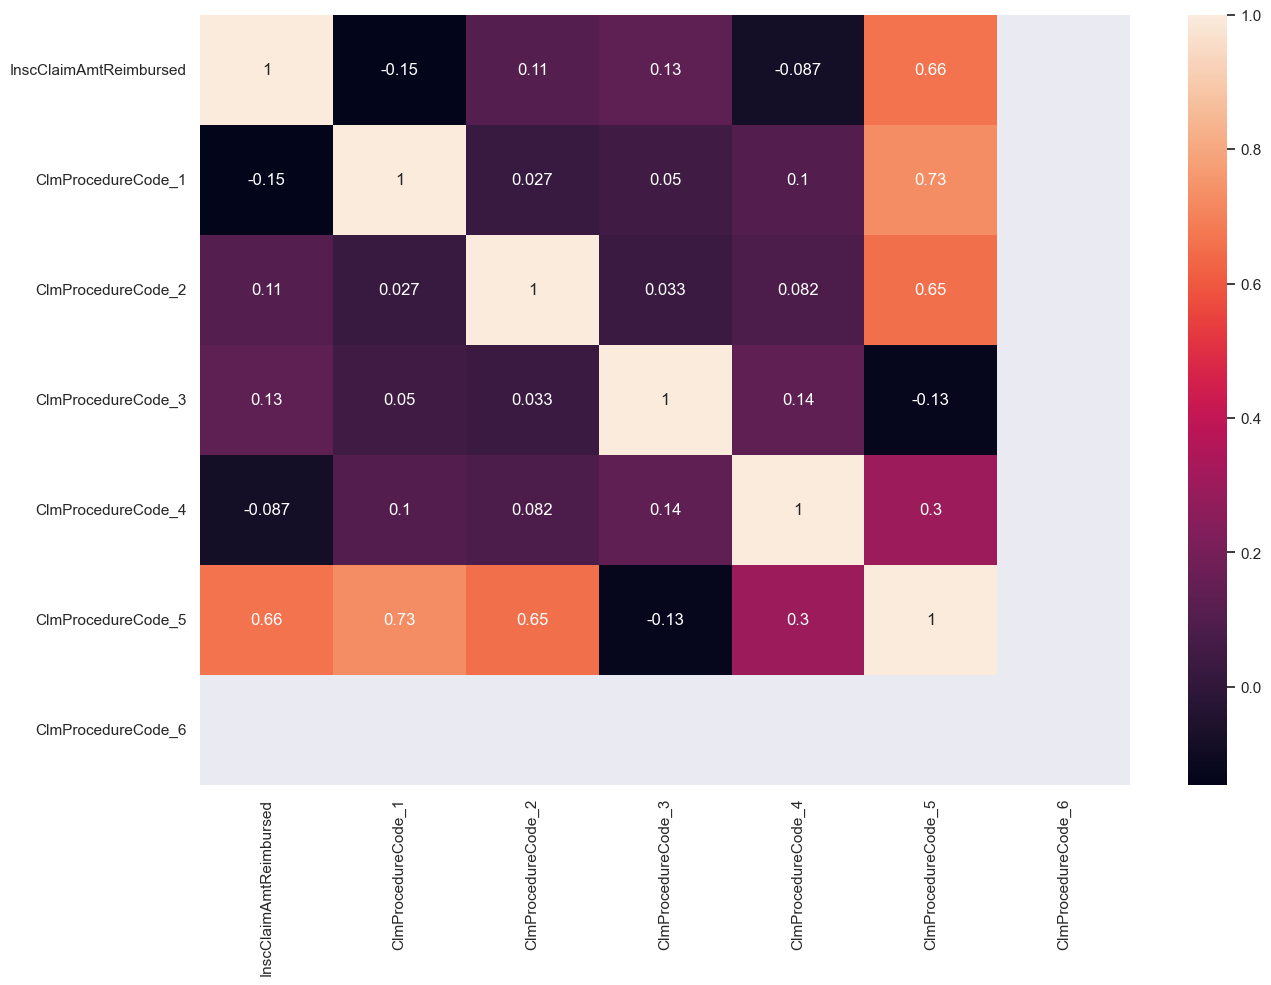

In [104]:
sns.heatmap(df_in_corr, annot=True)

# Exploratory Data Analysis

# Modeling